In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
import pickle

from neurolib.models.wc import WCModel
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

In [2]:
wc = WCModel()
dur = 2000
wc.params['duration'] = dur

control0 = np.zeros(dur*10+1)
control0[:1000] = 5.
control0[10000:11000] = -5.

ones = np.ones(dur*10+1)



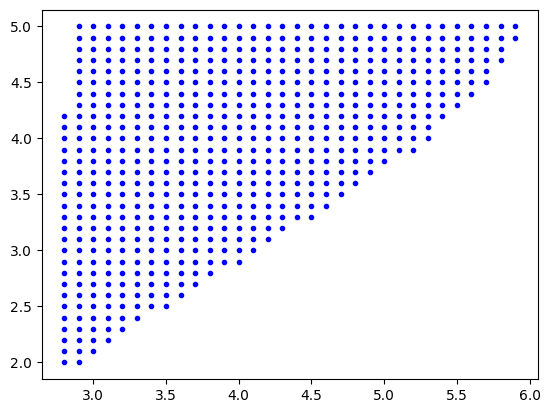

In [8]:
step = 0.1

exc_inputs = np.around(np.arange(0, 6., step), 3)
inh_inputs = np.around(np.arange(0, 5.1, step), 3)

limit_std_osc = 1e-2
limit_mean_osc = 1e-1
limit_down = 0.15

up = []
down = []
osc = []
bi = []

for i in inh_inputs:
    for e in exc_inputs:
    
        wc.params['exc_ext'] = e * ones + control0
        wc.params['inh_ext'] = i * ones
        wc.run()

        mean_std_0 = [np.mean(wc.exc[0,9000:9999]), np.std(wc.exc[0,9000:9999])]
        mean_std_1 = [np.mean(wc.exc[0,-1000:]), np.std(wc.exc[0,-1000:])]

        if mean_std_0[1] < limit_std_osc:    # first state steady
            if mean_std_1[1] < limit_std_osc:    # second state steady
                if np.abs(mean_std_0[0] - mean_std_1[0]) < limit_std_osc:   # same steady state
                    if mean_std_0[0] < limit_down:
                        #print("down state")
                        down.append([e, i])
                    elif mean_std_0[0] >= limit_down:
                        #print("up state")
                        up.append([e, i])
                else:   # bistable
                    #print("bistable state")
                    bi.append([e, i])
            else:
                print("first steady, second ?", e,i)
                plt.plot(wc.t, wc.exc[0,:])
                plt.show()
        else:       # first state osc
            if np.abs(mean_std_0[0] - mean_std_1[0]) < limit_mean_osc:   # same oscillation
                #print("oscillatory state")
                osc.append([e,i])

            else:
                print("oscillation with different mean?", e,i)
                plt.plot(wc.t, wc.exc[0,:])
                plt.show()

plt_wc_statespace_bi(bi)


In [7]:
ms = 3

def plt_wc_statespace(up, down, bi, osc):
    for point in up:
        plt.plot(point[0], point[1], color = 'red', marker='o', markersize=ms)

    for point in down:
        plt.plot(point[0], point[1], color = 'grey', marker='o', markersize=ms)

    for point in bi:
        plt.plot(point[0], point[1], color = 'blue', marker='o', markersize=ms)

    for point in osc:
        plt.plot(point[0], point[1], color = 'green', marker='o', markersize=ms)

    plt.show()

def plt_wc_statespace_bi(bi):

    for point in bi:
        plt.plot(point[0], point[1], color = 'blue', marker='o', markersize=ms)
        plt.xlim(0., 5)
        plt.ylim(0., 5.)

    plt.show()

In [6]:
boundary_LC_e = []
boundary_LC_i = []

for point in down:
    if point[1] > 2:
        continue
    if  [np.around(point[0] + step,2), np.around(point[1],3)]  not in down:
        boundary_LC_e.append( point[0] + step/2.)
        boundary_LC_i.append(point[1])
for point in osc[::-1]:
   if [np.around(point[0] + step,2), np.around(point[1],3)] not in osc:
    boundary_LC_e.append( point[0] + step/2.)
    boundary_LC_i.append(point[1])

boundary_bi_e = []
boundary_bi_i = []
for point in down[::-1]:
    if point[1] < 2:
        continue
    if [np.around(point[0] + step,2), np.around(point[1],3)] not in down:
        boundary_bi_e.append( point[0] + step/2.)
        boundary_bi_i.append(point[1])
for point in bi:
   if [np.around(point[0] + step,2), np.around(point[1],3)] not in bi:
    boundary_bi_e.append( point[0] + step/2.)
    boundary_bi_i.append(point[1])

boundary_du_e = []
boundary_du_i = []
for point in down:
    if point[1] < 1 or point[1] > 2:
        continue
    if [np.around(point[0] + step,2), np.around(point[1],3)] not in down:
        if [np.around(point[0] + step,2), np.around(point[1],3)] in up:
            boundary_du_e.append( point[0] + step/2.)
            boundary_du_i.append(point[1])

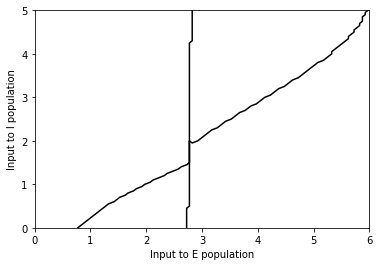

In [7]:
plt.plot(boundary_LC_e, boundary_LC_i, color='black')
plt.plot(boundary_bi_e, boundary_bi_i, color='black')
plt.xlabel('Input to E population')
plt.ylabel('Input to I population')
plt.xlim(0,6)
plt.ylim(0,5)

plt.show()

In [8]:
with open('boundary_osc.pickle','wb') as f:
    pickle.dump([boundary_LC_e, boundary_LC_i], f)
    
with open('boundary_bi.pickle','wb') as f:
    pickle.dump([boundary_bi_e, boundary_bi_i], f)